In [73]:
import os
import pickle
import tarfile
import datetime
import numpy as np
import urllib.request
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from keras.utils import plot_model
from keras import layers, Model
import keras

In [75]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


In [93]:
%load_ext tensorboard

In [76]:
HISTORY_DIR = './history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [77]:
def get_name(prefix: str | None, suffix: str | None, separator: str = "/") -> str | None:
    return prefix and suffix and prefix + separator + suffix 

In [78]:
def get_data():
    if not os.path.exists('cifar-10-batches-py/'):
        urllib.request.urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 'cifar-10-python.tar.gz')
        file = tarfile.open('cifar-10-python.tar.gz', 'r:gz')
        file.extractall()
        
    X, y = [], []
    for i in range(1, 6):
        d = pickle.load(open(os.path.join('cifar-10-batches-py', f'data_batch_{i}'), 'rb'), encoding='bytes')
        X.append(d[b'data'])
        y.append(d[b'labels'])
        
    d = pickle.load(open(os.path.join('cifar-10-batches-py', 'test_batch'), 'rb'), encoding='bytes')
        
    return (
        np.concatenate(X, axis=0).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.concatenate(y, axis=0),
        pickle.load(open('cifar-10-batches-py/batches.meta', 'rb'))['label_names'],
        np.array(d[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.array(d[b'labels'])
    )

In [79]:
def plot_confusion_matrix(model: tf.keras.models.Model, X: np.ndarray, y: np.ndarray, labels: list[str], batch_size: int = 8, **kwargs):
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y,
        model.predict(X, verbose=False, batch_size=batch_size).argmax(axis=-1),
        display_labels=labels,
        xticks_rotation='vertical',
        **kwargs
    )

In [80]:
X, y, labels, X_test, y_test = get_data()

# Preprocessing

In [81]:
# 1. Normalization
X_train = X / 255
X_test = X_test / 255

In [82]:
# 2. Train/Validation datasets
X_train, X_val, y_train, y_val = train_test_split(X_train, y, test_size=0.25, random_state=42)

In [83]:
# 3. Data Augmentation

batch_size = 64

data_generator = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = data_generator.flow(X_train, y_train, batch_size)

# Model

In [84]:
INPUT_SHAPE = (32, 32, 3)

input = Input(shape=INPUT_SHAPE)

x = Conv2D(32, 3, activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.000001))(input)
x = Conv2D(32, 3, activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.000001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, 3, activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.000001))(x)
x = Conv2D(64, 3, activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.000001))(x)
x = Conv2D(64, 3, activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.000001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, 3, activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.000001))(x)
x = Conv2D(128, 3, activation='relu', padding="same", kernel_regularizer=regularizers.l2(0.000001))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.000001))(x)
output = Dense(10, activation="softmax")(x)

model = Model(input, output)

In [85]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 851,946 (3.25 MB)

 Trainable params: 851,498 (3.25 MB)

 Non-trainable params: 448 (1.75 KB)

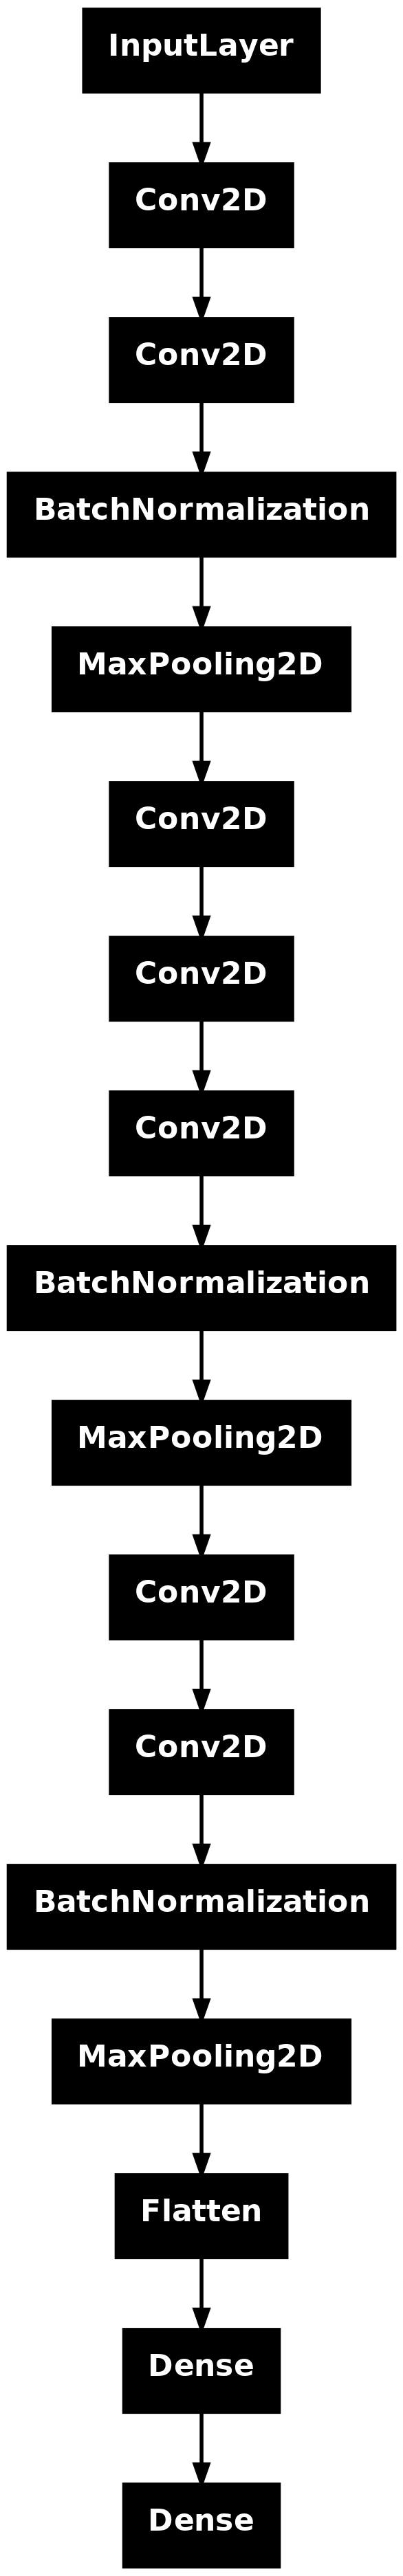

In [86]:
plot_model(model)

In [87]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"], optimizer="Adam")

In [88]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [89]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(logdir, 'model.keras'),
    save_best_only=True
)

In [90]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(logdir, 'logs.keras'),    
)

In [94]:
%tensorboard --logdir $logdir

In [91]:
EPOCHS = 100

In [92]:
keras.utils.set_random_seed(812)

history = model.fit(train_generator, validation_data=(X_val, y_val), epochs=EPOCHS, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/100


/root/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-10-18 22:46:58.629294: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads



531/586 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.3163 - loss: 2.0051

2024-10-18 22:47:31.668547: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_3', 4 bytes spill stores, 12 bytes spill loads



586/586 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.3226 - loss: 1.9785 - val_accuracy: 0.5081 - val_loss: 1.3410
Epoch 2/100


2024-10-18 22:47:39.382425: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_13', 4 bytes spill stores, 4 bytes spill loads



586/586 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.4873 - loss: 1.4230 - val_accuracy: 0.5113 - val_loss: 1.3848
Epoch 3/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.5587 - loss: 1.2317 - val_accuracy: 0.6146 - val_loss: 1.1157
Epoch 4/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.6183 - loss: 1.0828 - val_accuracy: 0.6557 - val_loss: 1.0278
Epoch 5/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.6634 - loss: 0.9711 - val_accuracy: 0.6520 - val_loss: 1.0503
Epoch 6/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.6836 - loss: 0.9012 - val_accuracy: 0.6784 - val_loss: 0.9789
Epoch 7/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.7017 - loss: 0.8501 - val_accuracy: 0.6714 - val_loss: 1.0363
Epoch 8/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.7207 - loss: 0.8030 - val_accuracy: 0.7306 - val_loss: 0.8058
Epoch 9/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.7364 - loss: 0.7543 - val_

In [95]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8650 - loss: 0.5009


[0.49979379773139954, 0.868399977684021]

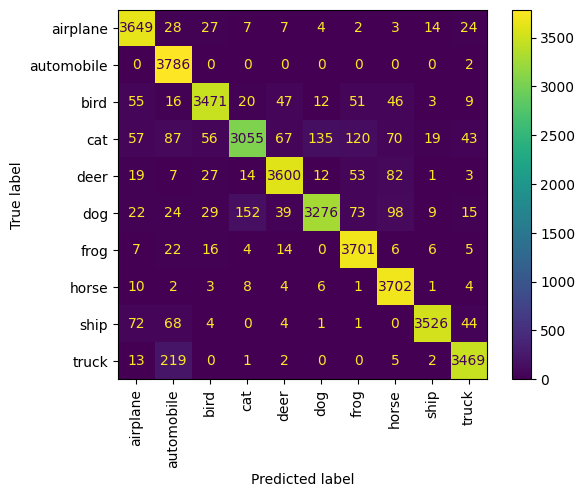

In [96]:
plot_confusion_matrix(model, X_train, y_train, labels=labels)

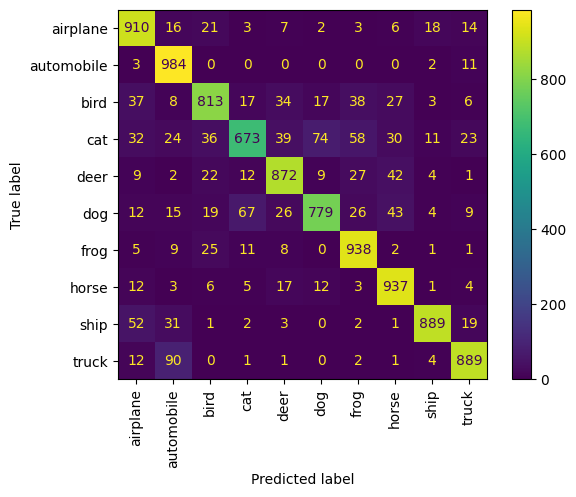

In [97]:
plot_confusion_matrix(model, X_test, y_test, labels=labels)

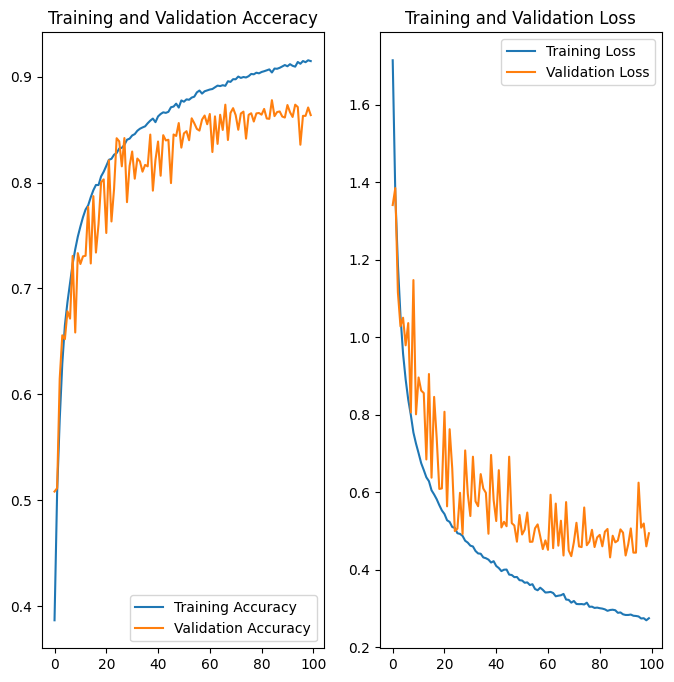

In [98]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(EPOCHS)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Acceracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [99]:
model.save("model-v4.keras")

In [100]:
loaded = keras.saving.load_model("model-v4.keras")

In [101]:
loaded.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8650 - loss: 0.5009


[0.49979379773139954, 0.868399977684021]